#**Машинное обучение в бизнесе: Кредитный дефолт клиентов банка**





***1. Определение бизнес-задачи и задачи машинного обучения***

*Бизнес-задача:*

Банк сталкивается с проблемой кредитных дефолтов, когда клиенты не могут своевременно погашать свои кредитные задолженности. Это создает финансовые риски и влияет на прибыльность банка. Основная бизнес-задача заключается в снижении этих рисков путем предсказания вероятности дефолта клиентов, что позволит банку принять превентивные меры, такие как изменение условий кредита, предложение реструктуризации долга или отказ в предоставлении кредита потенциально ненадежным заемщикам.

*Задача машинного обучения:*

Построить модель машинного обучения для классификации клиентов банка на две категории: тех, кто с высокой вероятностью допустит дефолт по кредиту (1), и тех, кто этого не сделает (0). Модель должна учитывать различные характеристики клиентов, такие как история платежей, уровень дохода, задолженность, и другие параметры, чтобы предсказать вероятность дефолта.

*Ссылка на дата-сет:* https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls


***2. Анализ и обработка дата-сета***

*Первичный анализ данных*

In [1]:
import pandas as pd

# Загрузка данных
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls'
data = pd.read_excel(url, header=1)

# Вывод первых строк дата-сета
print(data.head().to_string(index=False))

# Информация о дата-сете
print(data.info())

# Проверка на наличие пропущенных значений
print(data.isnull().sum())

 ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month
  1      20000    2          2         1   24      2      2     -1     -1     -2     -2       3913       3102        689          0          0          0         0       689         0         0         0         0                           1
  2     120000    2          2         2   26     -1      2      0      0      0      2       2682       1725       2682       3272       3455       3261         0      1000      1000      1000         0      2000                           1
  3      90000    2          2         2   34      0      0      0      0      0      0      29239      14027      13559      14331      14948      15549      1518      1500      1000      1000      1000      5000                           0
  4      50000    2          2  

*Предобработка данных*

In [2]:
# Переименуем столбец целевого признака для удобства
data.rename(columns={'default payment next month': 'default'}, inplace=True)

# Преобразование целевого признака в числовой формат
data['default'] = data['default'].astype(int)

# Проверим и удалим возможные дубликаты
data.drop_duplicates(inplace=True)

# Заполнение пропущенных значений
data.fillna(data.mean(), inplace=True)

*Разведывательный анализ данных (Exploratory Data Analysis)*


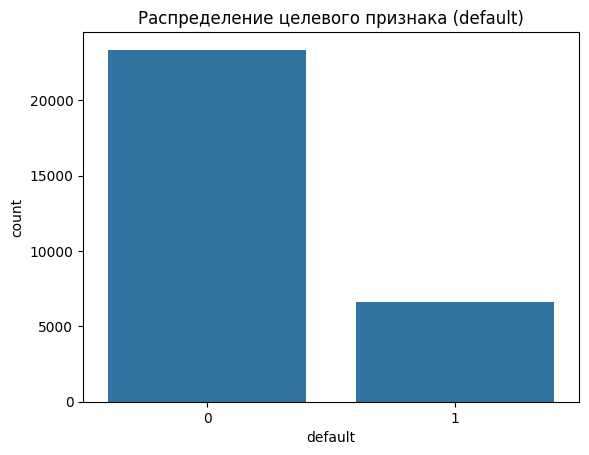

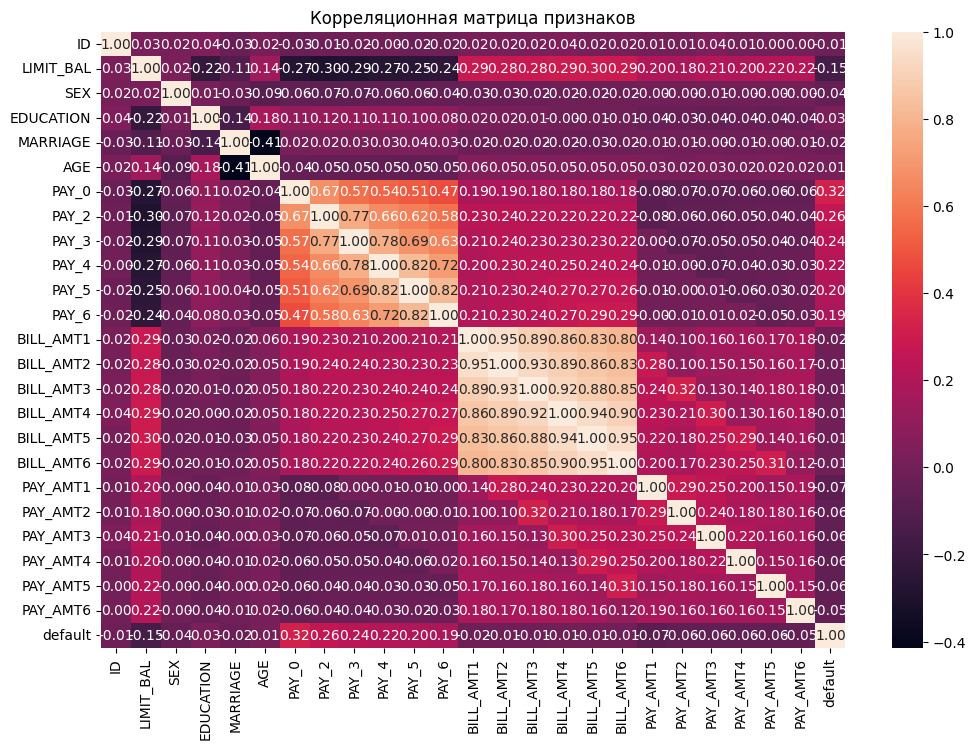

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Распределение целевого признака
sns.countplot(x='default', data=data)
plt.title('Распределение целевого признака (default)')
plt.show()

# Корреляция признаков
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Корреляционная матрица признаков')
plt.show()

Выводы:

Несбалансированные данные:

- На графике видно, что количество наблюдений для класса 0 (отсутствие дефолта) значительно превышает количество наблюдений для класса 1 (наличие дефолта). Это говорит о том, что данные несбалансированы.

Проблема смещения модели:

- При обучении модели на таких данных она может стать смещенной в сторону преобладающего класса, то есть модель может часто предсказывать отсутствие дефолта, игнорируя случаи наличия дефолта.

*Создание признаков (Feature Engineering)*

In [4]:
# Создание дополнительных признаков (например, отношение лимита кредитной карты к задолженности)
data['LIMIT_BAL_RATIO'] = data['LIMIT_BAL'] / (data['BILL_AMT1'] + 1)

# Удаление лишних признаков, если такие имеются
data.drop(columns=['ID'], inplace=True)

*Отбор признаков (Feature selection)*

In [5]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif

# Проверка на бесконечные значения и большие числа
X = data.drop(columns=['default'])
y = data['default']

# print(np.isinf(X).sum())  # Проверка на наличие бесконечных значений
# print((X > np.finfo(np.float64).max).sum())  # Проверка на наличие слишком больших чисел

# Замена бесконечных значений на NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Заполнение NaN значений средними значениями по столбцам
X.fillna(X.mean(), inplace=True)

# Отбор 10 лучших признаков
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support(indices=True)]
print(selected_features)

Index(['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT4'],
      dtype='object')


*Подготовка данных (Data Preparation)*

In [6]:
from sklearn.model_selection import train_test_split

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

***3. Выбор метрики для оценки моделей***

Метрики для оценки:


*   *Accuracy:* Процент правильно классифицированных наблюдений.
*   *Precision:* Доля правильно классифицированных положительных наблюдений среди всех, предсказанных как положительные.
*   *Recall:* Доля правильно классифицированных положительных наблюдений среди всех истинных положительных.
*   *F1-score:* Гармоническое среднее между Precision и Recall, полезное для несбалансированных классов.



Обоснование:

Для задачи прогнозирования дефолта по кредитным картам важны метрики Precision и Recall, так как важно минимизировать ложные положительные и ложные отрицательные результаты. F1-score будет полезным для общей оценки баланса между Precision и Recall.

***4. Построение моделей машинного обучения***

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Логистическая регрессия
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
print("Logistic Regression")
print(classification_report(y_test, lr_predictions))

# Дерево решений
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
print("Decision Tree")
print(classification_report(y_test, dt_predictions))

# Случайный лес
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
print("Random Forest")
print(classification_report(y_test, rf_predictions))

# Метод опорных векторов
svc_model = SVC()
svc_model.fit(X_train, y_train)
svc_predictions = svc_model.predict(X_test)
print("Support Vector Machine")
print(classification_report(y_test, svc_predictions))

Logistic Regression
              precision    recall  f1-score   support

           0       0.83      0.95      0.88      4687
           1       0.60      0.29      0.39      1313

    accuracy                           0.80      6000
   macro avg       0.71      0.62      0.64      6000
weighted avg       0.78      0.80      0.77      6000

Decision Tree
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      4687
           1       0.39      0.38      0.39      1313

    accuracy                           0.73      6000
   macro avg       0.61      0.61      0.61      6000
weighted avg       0.73      0.73      0.73      6000

Random Forest
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      4687
           1       0.60      0.37      0.45      1313

    accuracy                           0.81      6000
   macro avg       0.72      0.65      0.67      6000
weighted avg       0.79   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***5. Диагностика лучшей модели***

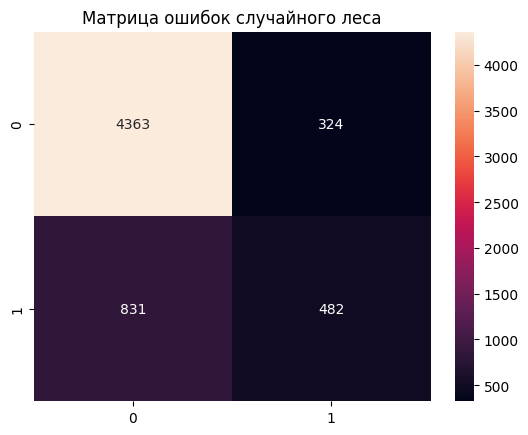

In [8]:
# Лучшая модель - случайный лес (Random Forest)
from sklearn.metrics import confusion_matrix

# Матрица ошибок
cm = confusion_matrix(y_test, rf_predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Матрица ошибок случайного леса')
plt.show()

***6. Подбор гиперпараметров для лучшей модели***

In [9]:
from sklearn.model_selection import GridSearchCV

# Определение гиперпараметров для подбора
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Поиск по сетке
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='f1')
grid_search.fit(X_train, y_train)

# Лучшая модель
best_rf_model = grid_search.best_estimator_
print("Лучшие Параметоры:", grid_search.best_params_)

Лучшие Параметоры: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}


***7. Построение ансамблевой модели машинного обучения***

In [10]:
from sklearn.ensemble import VotingClassifier

# Ансамблевая модель с голосованием
voting_model = VotingClassifier(estimators=[
    ('lr', lr_model),
    ('dt', dt_model),
    ('rf', best_rf_model),
    ('svc', svc_model)
], voting='hard')

voting_model.fit(X_train, y_train)
voting_predictions = voting_model.predict(X_test)
print("Voting Classifier")
print(classification_report(y_test, voting_predictions))


Voting Classifier
              precision    recall  f1-score   support

           0       0.80      0.98      0.88      4687
           1       0.67      0.15      0.25      1313

    accuracy                           0.80      6000
   macro avg       0.74      0.56      0.56      6000
weighted avg       0.77      0.80      0.74      6000



***Вывод***

Мы рассмотрели бизнес-задачу прогнозирования дефолта по кредитным картам и поставили задачу машинного обучения. Мы провели анализ и обработку данных, включая предобработку и разведывательный анализ, создали и отобрали признаки. Были выбраны метрики для оценки моделей, и построены четыре модели машинного обучения. Проведена диагностика и подбор гиперпараметров для лучшей модели (случайный лес). Наконец, была построена ансамблевая модель, которая объединяет несколько алгоритмов для улучшения точности прогноза. В результате, мы получили мощный инструмент для прогнозирования дефолта по кредитным картам, что может помочь банкам в снижении финансовых рисков и улучшении управления кредитными портфелями.